In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_precision_recall_curve

from cf_matrix import make_confusion_matrix as cm

pd.set_option('display.max_columns', None)

In [181]:
df = pd.read_csv('./Data/df_cleaned.csv', index_col=0)
df = df.reset_index(drop=True)

# Removing Sources of Data Leakage

In [182]:
drop_col = ['yards', 'firstdown', 'batted_pass', 'interception',
            'incompletion_type', 'touchdown']

In [183]:
df = df.drop(drop_col, axis=1)

# Model Training

In [184]:
df['play_action'] = df['play_action'].map(lambda x: 1 if x == True else 0)
df['run_pass_option'] = df['run_pass_option'].map(lambda x: 1 if x == True else 0)
df['blitz_y'] = df['blitz_y'].map(lambda x: 1 if x == True else 0)


In [185]:
df.head()

,name,complete,att_yards,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,direction,quarter,yards_to_goal,down,yards_to_first,hash_mark,play_action,run_pass_option,blitz_y,qb_at_snap,players_rushed,pocket_location,pass_route,seconds_left_in_half,att_dist
0,Aaron Rodgers,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134,short right,2.0,31,1,10,Right Hash,0,0,0,Shotgun,4.0,Middle,Flat,120,short
1,Aaron Rodgers,1.0,13.0,1.0,0.0,0.0,0.0,0.0,1.820,short right,2.0,14,2,9,Left Hash,0,0,0,Shotgun,4.0,Middle,Go,858,medium
2,Aaron Rodgers,1.0,5.0,0.0,0.0,1.0,0.0,0.0,1.855,short middle,1.0,27,1,10,Left Hash,0,0,1,Shotgun,6.0,Middle,Slant,913,short
3,Aaron Rodgers,1.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.191,short left,1.0,32,2,5,Right Hash,1,1,0,Shotgun,4.0,Middle,WR Screen,953,behind
4,Aaron Rodgers,1.0,-5.0,0.0,0.0,0.0,0.0,0.0,2.697,short right,1.0,56,2,7,Left Hash,0,0,0,Shotgun,4.0,Middle,Flat,1203,behind


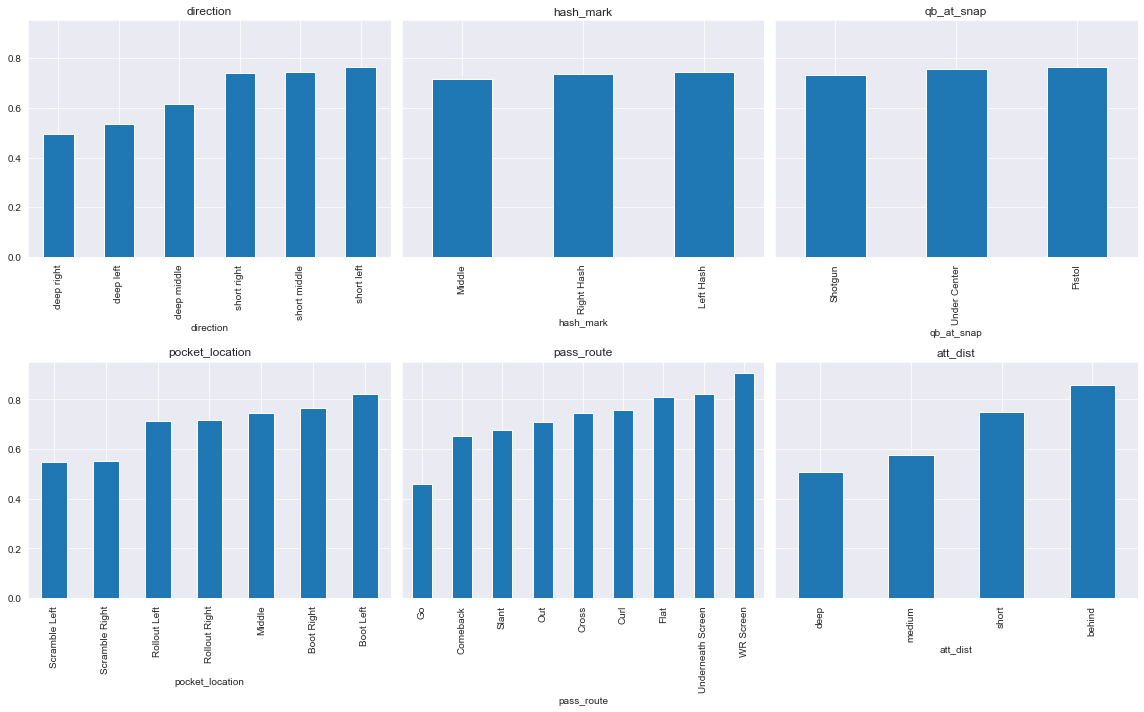

In [186]:
cat = ['direction', 'hash_mark', 'qb_at_snap', 'pocket_location', 'pass_route', 'att_dist']
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(16,10),sharey=True)
for col, ax in zip(cat, axes.flatten()):
    (df.groupby(col)
        .mean()['complete']
        .sort_values()
        .plot
        .bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()
    


In [202]:
dummies = pd.get_dummies(df[cat], drop_first=True)
df = df.drop(cat, axis=1)
df = pd.concat([df, dummies], axis=1)

# Train-Test Split

In [204]:
X = df.drop(['name', 'complete'], axis=1)
y = df['complete']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2,random_state=123)

In [188]:
scale_cols = ['att_yards', 'pocket_time', 'yards_to_goal', 'yards_to_first', 'players_rushed',
              'seconds_left_in_half', 'quarter', 'down']

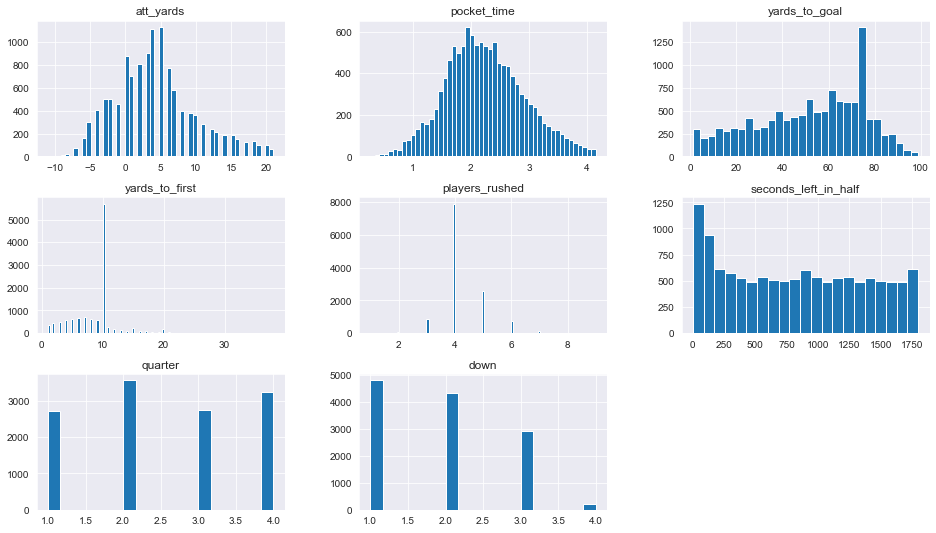

In [205]:
X[scale_cols].hist(figsize=(16,9), bins='auto');

## Defining Helper Functions

In [15]:
def build_model(model, X, y, random_state=123, decision_function=True):
    
    X_train, X_test, y_train, y_test = tts(X, y, random_state=random_state,
                                           test_size=0.2)
    model_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if decision_function == True:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_test, y_pred)
    
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    all_models.append(model_dict)
    
    return model_dict

In [16]:
def plot_matrix(cfm):
    
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Incomplete', 'Complete']
    matrix = cm(cfm, group_names=labels, figsize=(10,6), fontsize=18,
               categories=categories, cbar=False, cmap='Purples')
    
    return matrix

# Baseline Model

In [227]:
# empty list to append build_model function results
# for all models
all_models = []

In [228]:
mms_pipe = Pipeline([('mms', MinMaxScaler()), 
                     ('ss', StandardScaler()), 
                     ('log', LogisticRegression(random_state=123))])

In [229]:
base_pipe = Pipeline([('mms', MinMaxScaler()), 
                     ('ss', StandardScaler()), 
                     ('log', LogisticRegression(random_state=123))])

baseline_log = build_model(base_pipe,X,y)

Accuracy: 0.756
Precision: 0.771
Recall: 0.959
F1 Score: 0.855
AUC: 0.69


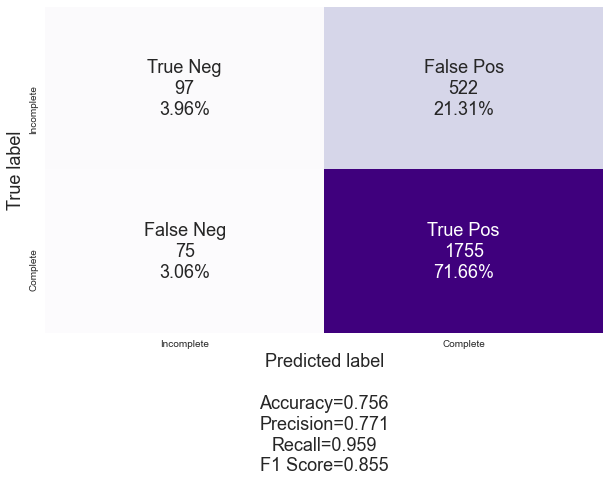

In [230]:
plot_matrix(baseline_log['cfm'])

## Determining Feature Importance

In [231]:
feature_names = X.columns
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

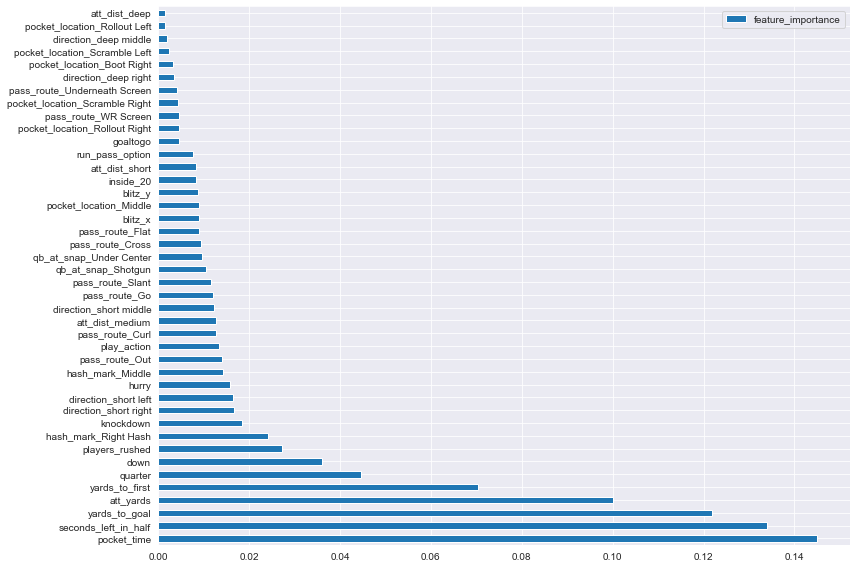

In [232]:
importances = forest.feature_importances_
forest_importances = pd.DataFrame(importances, index=feature_names, 
                                  columns=['feature_importance']
                                 ).sort_values('feature_importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.barh(ax=ax)

fig.tight_layout()

In [233]:
top5 = forest_importances[:5]
ttop5 = top5.transpose()

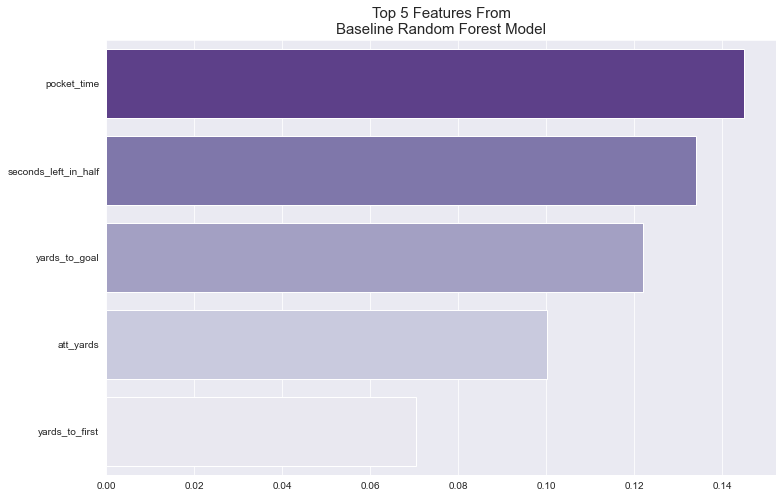

In [234]:
plt.figure(figsize=(12,8))
sns.barplot(data=ttop5, orient='h', palette='Purples_r')

plt.title('Top 5 Features From\nBaseline Random Forest Model', fontsize=15)

plt.savefig('./Images/feature_importance.png', format='png')
plt.show()

In [235]:
top5 = top5.index

## Logistic Regression Top 5 Features

In [236]:
pipe = Pipeline([('mms', MinMaxScaler()), 
                 ('ss', StandardScaler()), 
                 ('log', LogisticRegression(random_state=123))])

top5_log = build_model(pipe,X[top5],y )

Accuracy: 0.748
Precision: 0.755
Recall: 0.981
F1 Score: 0.853
AUC: 0.64


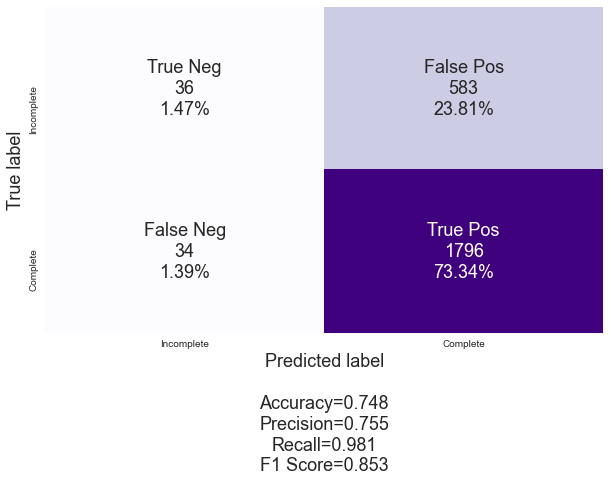

In [237]:
plot_matrix(top5_log['cfm'])

## Random Forest Top 5 Features

In [238]:
top5_rf = build_model(RandomForestClassifier(n_estimators=500,
                                             criterion='gini',
                                             random_state=123),
                        X[top5],y, decision_function=False)

Accuracy: 0.739
Precision: 0.766
Recall: 0.937
F1 Score: 0.843
AUC: 0.64


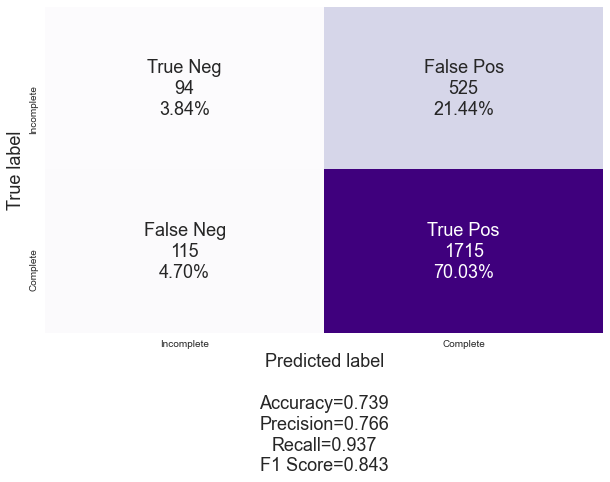

In [239]:
plot_matrix(top5_rf['cfm'])

## KNN Top 5 Features

In [240]:
pipe = Pipeline([('mms', MinMaxScaler()), 
                 ('ss', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])


top5_knn = build_model(KNeighborsClassifier(), X[top5], y, decision_function=False)

Accuracy: 0.702
Precision: 0.755
Recall: 0.889
F1 Score: 0.816
AUC: 0.556


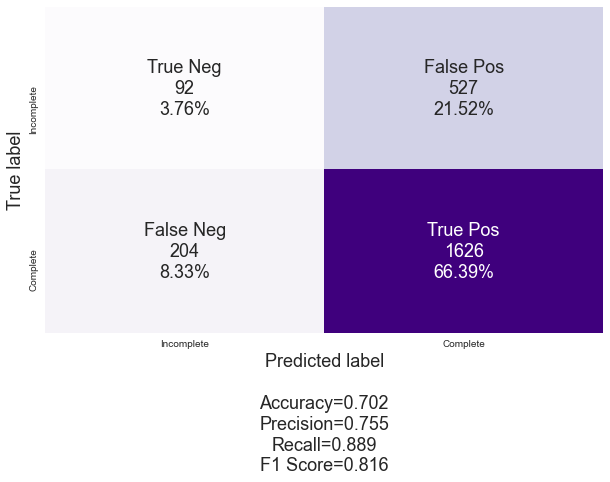

In [241]:
plot_matrix(top5_knn['cfm'])

## Decision Tree Classifier Top 5 Features

In [242]:
top5_tree = build_model(DecisionTreeClassifier(
                                               random_state=123),
                        X[top5], y, decision_function=False)

Accuracy: 0.64
Precision: 0.769
Recall: 0.74
F1 Score: 0.754
AUC: 0.541


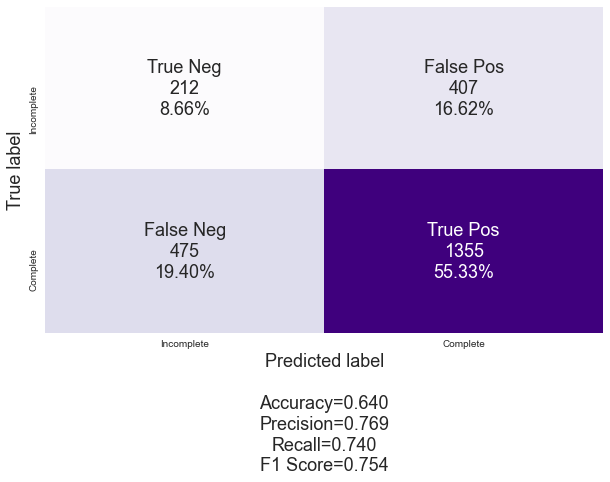

In [243]:
plot_matrix(top5_tree['cfm'])

## Gradient Boosting Classifier Top 5 Features

In [244]:
top5_gb = build_model(GradientBoostingClassifier(random_state=123,
                                                 n_estimators=1000),X[top5], y)

Accuracy: 0.733
Precision: 0.763
Recall: 0.932
F1 Score: 0.839
AUC: 0.622


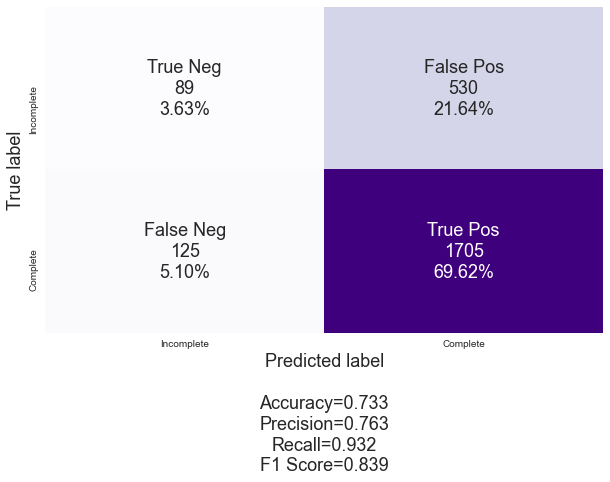

In [245]:
plot_matrix(top5_gb['cfm'])

## AdaBoost Classifier

In [246]:
top5_ada = build_model(AdaBoostClassifier(random_state=123),
                       X[top5], y)

Accuracy: 0.749
Precision: 0.755
Recall: 0.984
F1 Score: 0.854
AUC: 0.655


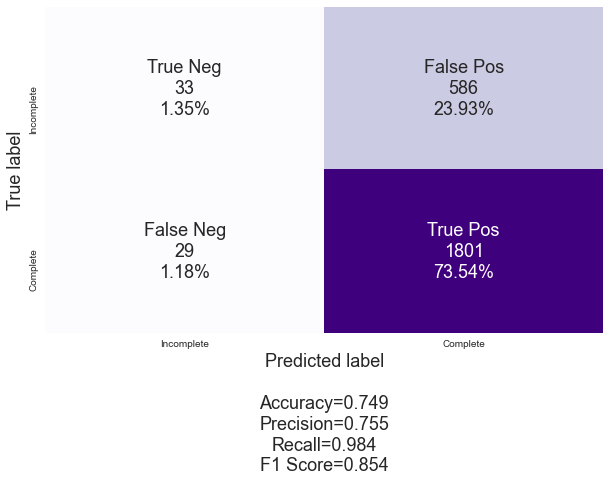

In [247]:
plot_matrix(top5_ada['cfm'])

## XGBoost Classifier Top 5 Features

In [248]:
top5_xgb = build_model(xgb.XGBClassifier(random_state=123,
                                         n_estimators=500),
                       X[top5], y, decision_function=False)

[15:57:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/scott/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.703
Precision: 0.768
Recall: 0.864
F1 Score: 0.813
AUC: 0.598


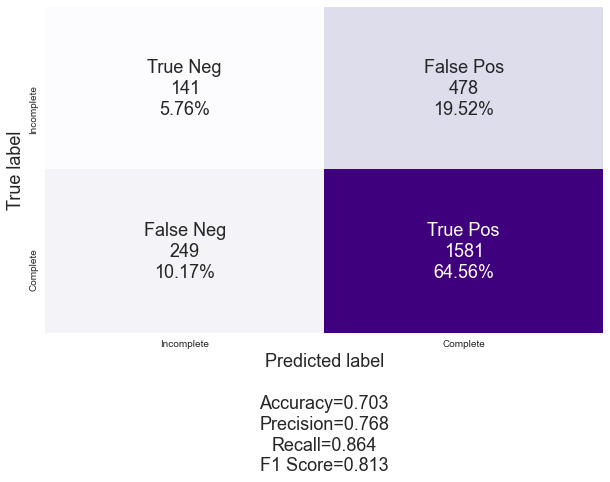

In [249]:
plot_matrix(top5_xgb['cfm'])

# Logistic Regression GridSearchCV

In [250]:
pipe = Pipeline([('mms', MinMaxScaler()), 
                 ('ss', StandardScaler()), 
                 ('log', LogisticRegression(random_state=123))])


param_grid = [
    {'log__penalty' : ['l1', 'l2'],
     'log__solver' : ['liblinear', 'lbfgs'],
     'log__C' : [0.001, 0.01, 0.1, 1],
     'log__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
     'log__max_iter' : list(range(50, 101, 10))}
]


gs_log = GridSearchCV(pipe, 
                      param_grid=param_grid,
                      scoring='f1',
                      cv=5, verbose=False, n_jobs=-1)

gs_log.fit(X_train, y_train)
gs_log.best_params_
# best_model = buid_model(clf, X[top5])

/Users/scott/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8478005  0.8478005  0.8478005  0.8478005  0.8478005         nan
        nan        nan        nan        nan 0.84177328 0.84177328
 0.84177328 0.84199547 0.84234695 0.84817469 0.84817469 0.84817469
 0.84817469 0.84817469 0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005         nan        nan        nan        nan        nan
 0.84177328 0.84177328 0.84177328 0.84199547 0.84234695 0.84817469
 0.84817469 0.84817469 0.84817469 0.84817469 0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005         nan        nan        nan
        nan        nan 0.84177328 0.84177328 0.84177328 0.84199547
 0.84234695 0.84817469 0.84817469 0.84817469 0.84817469 0.84817469
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005         nan
        nan        nan        nan        nan 0.84177328 0.84177328
 0.84177328 0.84199547 0.84234695

{'log__C': 0.001,
 'log__max_iter': 50,
 'log__penalty': 'l2',
 'log__solver': 'lbfgs',
 'log__tol': 0.0001}

In [251]:
gs_log.score(X_train, y_train)

0.8488680154142582

In [252]:
test = build_model(gs_log.best_estimator_, X[top5], y, decision_function=False)

Accuracy: 0.748
Precision: 0.748
Recall: 1.0
F1 Score: 0.856
AUC: 0.641


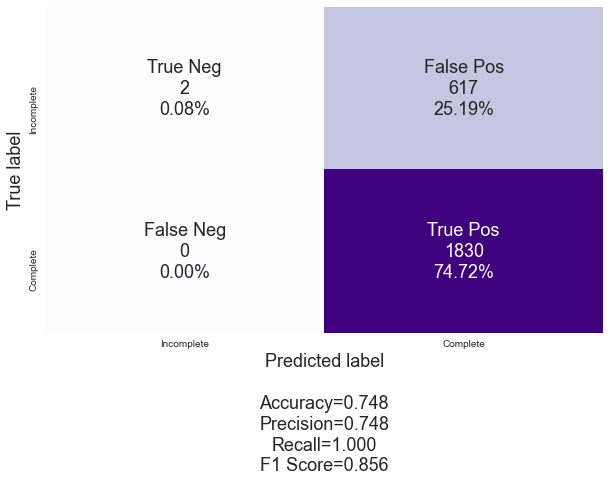

In [253]:
plot_matrix(test['cfm'])

Gridsearch models are returning near perfect recall scores. The models are heavily favoring the positive cases.

# Dealing With Class Imbalance Using SMOTE

Accuracy: 0.689
Precision: 0.788
Recall: 0.798
F1 Score: 0.793
AUC: 0.627


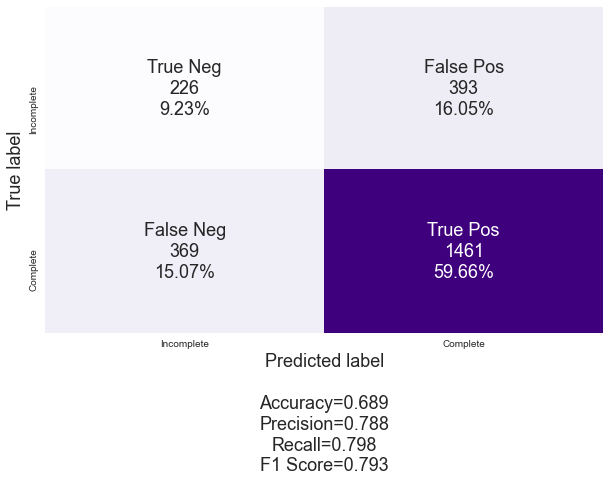

In [254]:
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state=123)
rf = RandomForestClassifier(random_state=123)
pipe = Pipeline([('smt', smt), ('rf', rf)])
rf_smote_pipe = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(rf_smote_pipe['cfm'])

Accuracy: 0.605
Precision: 0.808
Recall: 0.618
F1 Score: 0.701
AUC: 0.641


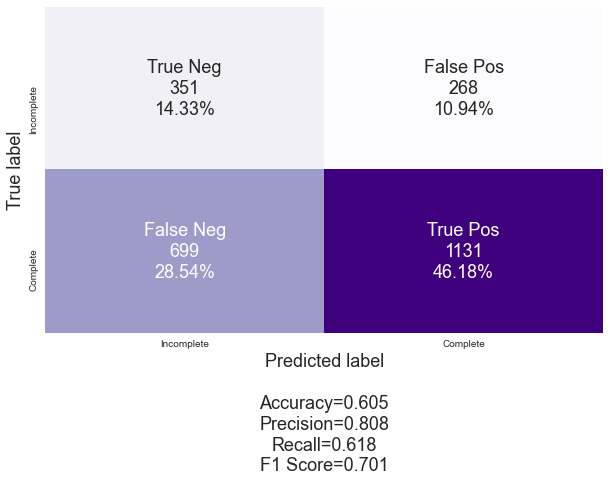

In [255]:
clf = LogisticRegression(random_state=123)
pipe = Pipeline([('mms', MinMaxScaler()), 
                 ('ss', StandardScaler()),
                 ('smt', smt), 
                 ('clf', clf)])

log_smote_pipe = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(log_smote_pipe['cfm'])

In [221]:
n_estimators = list(range(100,1001,100))
max_features = ['auto', 'sqrt']
max_depth = list(range(10,111,10))
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = ['True', 'False']

random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

smt = SMOTE(random_state=123)
under = RandomUnderSampler(random_state=123)
rf = RandomForestClassifier(random_state=123)
pipe = Pipeline([('smt', smt), 
                 ('under', under), 
                 ('rf', rf)])

rf_random = RandomizedSearchCV(estimator=pipe,
                               param_distributions=random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 2,
                               n_jobs = -1,
                               scoring = 'precision',
                               random_state=123)


In [49]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                             ('under',
                                              RandomUnderSampler(random_state=123)),
                                             ('rf',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__bootstrap': ['True', 'False'],
                                        'rf__max_depth': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100,
                                                          110],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf_

In [51]:
rf_random.best_estimator_['rf']

RandomForestClassifier(bootstrap='False', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10, random_state=123)

In [257]:
rf_random_best = RandomForestClassifier(bootstrap='False',
                                        max_depth=10,
                                        max_features='auto',
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=100,
                                        random_state=123)

# Undersample Majority in Random Forest Pipeline

Accuracy: 0.646
Precision: 0.802
Recall: 0.699
F1 Score: 0.747
AUC: 0.641


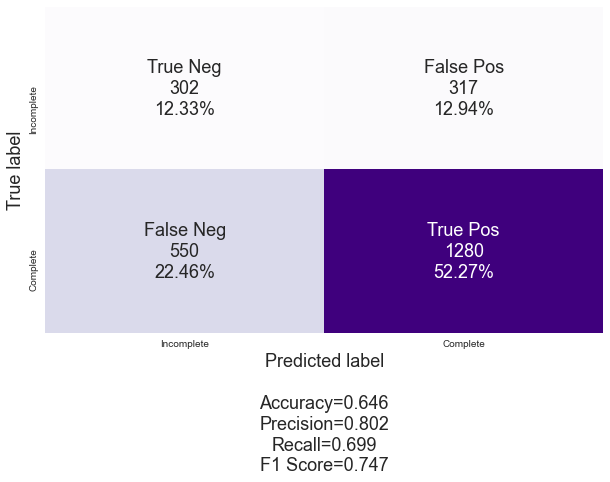

In [272]:
rf = rf_random_best
pipe = Pipeline([('smt', smt), ('under', under), ('rf', rf)])
rf_overUnder = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(rf_overUnder['cfm'])

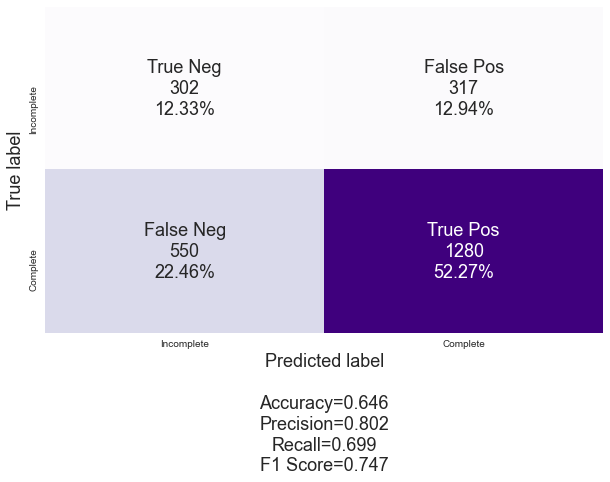

In [274]:
fig = plot_matrix(rf_overUnder['cfm'])
plt.savefig('./Images/final_cm.png', format='png')

In [55]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='recall', cv=cv, n_jobs=-1)
print(f'Mean recall: {round(np.mean(scores),3)}')

Mean recall: 0.784


In [56]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='precision', cv=cv, n_jobs=-1)
print(f'Mean precision: {round(np.mean(scores),3)}')

Mean precision: 0.791


In [57]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='f1', cv=cv, n_jobs=-1)
print(f'Mean f1: {round(np.mean(scores),3)}')

Mean f1: 0.787


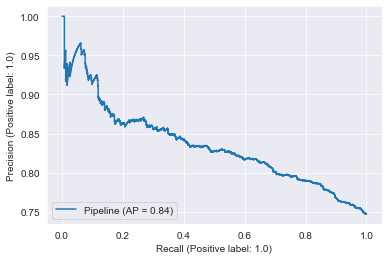

In [276]:
plot_precision_recall_curve(rf_overUnder['model'], X_test[top5], y_test)

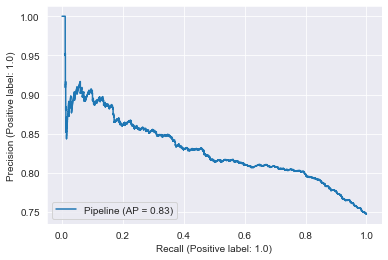

In [282]:
Xtop5 = X.loc[:,X.columns.isin(top5)]
X_train, X_test, y_train, y_test = tts(Xtop5, y, test_size=0.2, random_state=123)

log = LogisticRegression(random_state=123)
pipe = Pipeline([('mms', MinMaxScaler()), 
                 ('ss', StandardScaler()),
                 ('smt', smt), ('under', under), 
                 ('log', log)])

pipe.fit(X_train, y_train)
plot_precision_recall_curve(pipe, X_test, y_test)

In [285]:
build_model(pipe, Xtop5, y)

Accuracy: 0.605
Precision: 0.808
Recall: 0.618
F1 Score: 0.701
AUC: 0.641


{'model': Pipeline(steps=[('mms', MinMaxScaler()), ('ss', StandardScaler()),
                 ('smt', SMOTE(random_state=123)),
                 ('under', RandomUnderSampler(random_state=123)),
                 ('log', LogisticRegression(random_state=123))]),
 'y_pred': array([0., 1., 1., ..., 1., 1., 0.]),
 'y_score': array([-0.10257394,  0.31458066,  0.57363654, ...,  0.36723239,
         0.74973389, -0.46533063]),
 'fpr': array([0.        , 0.        , 0.        , 0.00161551, 0.00161551,
        0.00323102, 0.00323102, 0.00484653, 0.00484653, 0.00646204,
        0.00646204, 0.00807754, 0.00807754, 0.00969305, 0.00969305,
        0.01130856, 0.01130856, 0.01292407, 0.01292407, 0.01453958,
        0.01453958, 0.01615509, 0.01615509, 0.01938611, 0.01938611,
        0.02100162, 0.02100162, 0.02261712, 0.02261712, 0.02423263,
        0.02423263, 0.02584814, 0.02584814, 0.02746365, 0.02746365,
        0.02907916, 0.02907916, 0.03069467, 0.03069467, 0.03231018,
        0.03231018, 0.035541

In [286]:
df_models = pd.DataFrame(all_models)
df_models = df_models.loc[:,['model', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'params', 'cfm']]

In [287]:
df_models.sort_values('precision', ascending=False)

,model,accuracy,precision,recall,f1,auc,params,cfm
10,"(MinMaxScaler(), StandardScaler(), SMOTE(rando...",0.605145,0.808435,0.618033,0.700526,0.640766,"{'memory': None, 'steps': [('mms', MinMaxScale...","[[351, 268], [699, 1131]]"
13,"(MinMaxScaler(), StandardScaler(), SMOTE(rando...",0.605145,0.808435,0.618033,0.700526,0.640766,"{'memory': None, 'steps': [('mms', MinMaxScale...","[[351, 268], [699, 1131]]"
11,"(SMOTE(random_state=123), RandomUnderSampler(r...",0.645978,0.801503,0.699454,0.747009,0.641158,"{'memory': None, 'steps': [('smt', SMOTE(rando...","[[302, 317], [550, 1280]]"
12,"(SMOTE(random_state=123), RandomUnderSampler(r...",0.645978,0.801503,0.699454,0.747009,0.641158,"{'memory': None, 'steps': [('smt', SMOTE(rando...","[[302, 317], [550, 1280]]"
9,"(SMOTE(random_state=123), (DecisionTreeClassif...",0.688853,0.788026,0.798361,0.793160,0.627237,"{'memory': None, 'steps': [('smt', SMOTE(rando...","[[226, 393], [369, 1461]]"
0,"(MinMaxScaler(), StandardScaler(), LogisticReg...",0.756227,0.770751,0.959016,0.854638,0.690151,"{'memory': None, 'steps': [('mms', MinMaxScale...","[[97, 522], [75, 1755]]"
4,DecisionTreeClassifier(random_state=123),0.639853,0.769012,0.740437,0.754454,0.541463,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...","[[212, 407], [475, 1355]]"
7,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.703144,0.767848,0.863934,0.813062,0.597534,"{'objective': 'binary:logistic', 'use_label_en...","[[141, 478], [249, 1581]]"
2,"(DecisionTreeClassifier(max_features='auto', r...",0.738669,0.765625,0.937158,0.842752,0.640276,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[[94, 525], [115, 1715]]"
5,([DecisionTreeRegressor(criterion='friedman_ms...,0.732544,0.762864,0.931694,0.838868,0.622234,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","[[89, 530], [125, 1705]]"


1. gridsearch logreg models with high precision
2. code predict_proba with best model
    - input: game situation (down, quarter, etc.)
    - output: probability that pass will be completed
        - loop through all 6 directions to find probability of each
3. make 3 business recommendations
    - base off eda, not model

# Predicting Probability of a Complete Pass

In [305]:
best_precision = df_models.iloc[13]
model = best_precision['model']

In [306]:
model.predict_proba(X_test)

array([[0.52562103, 0.47437897],
       [0.42199705, 0.57800295],
       [0.36039814, 0.63960186],
       ...,
       [0.40920994, 0.59079006],
       [0.32087929, 0.67912071],
       [0.61427799, 0.38572201]])

In [311]:
pocket = float(input('time in pocket:'))
seconds_in_half = int(input('seconds left in half:'))
yards_goal = int(input('yards to goal:'))
att_yards = float(input('attempted yards:'))
ytf = int(input('yards to first:'))

game_situation = {
    'pocket_time': [pocket], # post-pass
    'seconds_left_in_half':[seconds_in_half],
    'yards_to_goal':[yards_goal],
    'att_yards':[att_yards], # post-pass
    'yards_to_first':[ytf]
}

time in pocket:4
seconds left in half:30
yards to goal:5
attempted yards:5
yards to first:5


In [312]:
test_situation = pd.DataFrame(game_situation, columns=X_test.columns)
test_situation

,att_yards,pocket_time,yards_to_goal,yards_to_first,seconds_left_in_half
0,5.0,4.0,5,5,30


In [315]:
model.predict_proba(test_situation)

array([[0.67186391, 0.32813609]])

## test X with only top5 cols and directions

In [345]:
test = X.loc[:,(X.columns.isin(top5) | X.columns.str.contains('direction'))]

In [346]:
directions = test.loc[:,test.columns.str.contains('direction')]
directions['direction_deep left'] = np.where(directions.sum(axis=1) != 1, 1, 0)

<ipython-input-346-94e2bbedfbf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directions['direction_deep left'] = np.where(directions.sum(axis=1) != 1, 1, 0)


In [352]:
test = test.assign(direction_deepleft = directions['direction_deep left'])

In [353]:
test

,att_yards,pocket_time,yards_to_goal,yards_to_first,seconds_left_in_half,direction_deep middle,direction_deep right,direction_short left,direction_short middle,direction_short right,direction_deepleft
0,0.0,3.134,31,10,120,0,0,0,0,1,0
1,13.0,1.820,14,9,858,0,0,0,0,1,0
2,5.0,1.855,27,10,913,0,0,0,1,0,0
3,-4.0,1.191,32,5,953,0,0,1,0,0,0
4,-5.0,2.697,56,7,1203,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
12240,6.0,1.862,77,11,274,0,0,0,1,0,0
12241,6.0,2.682,46,9,909,0,0,0,0,1,0
12242,15.0,2.795,62,10,1000,0,0,0,0,1,0
12243,1.0,2.970,75,10,1044,0,0,0,0,1,0


Accuracy: 0.606
Precision: 0.808
Recall: 0.619
F1 Score: 0.701
AUC: 0.642


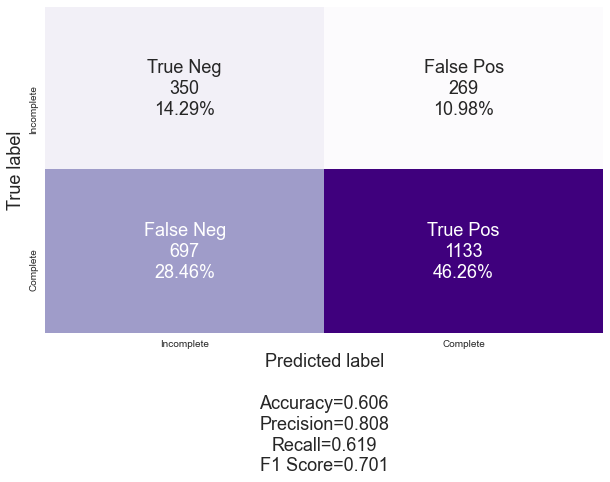

In [356]:
log_with_direc = build_model(pipe, test, y)
plot_matrix(log_with_direc['cfm'])

In [357]:
model = log_with_direc['model']

In [361]:
X_train, X_test, y_train, y_test = tts(test, y, test_size=0.2, random_state=123)

In [363]:
model.predict_proba(X_test)

array([[0.53845885, 0.46154115],
       [0.43517351, 0.56482649],
       [0.36237313, 0.63762687],
       ...,
       [0.39542637, 0.60457363],
       [0.32506627, 0.67493373],
       [0.63487738, 0.36512262]])

In [451]:
pocket = float(input('time in pocket:'))
seconds_in_half = int(input('seconds left in half:'))
yards_goal = int(input('yards to goal:'))
att_yards = float(input('attempted yards:'))
ytf = int(input('yards to first:'))

game_situation = {
    'pocket_time': [pocket], # post-pass
    'seconds_left_in_half':[seconds_in_half],
    'yards_to_goal':[yards_goal],
    'att_yards':[att_yards], # post-pass
    'yards_to_first':[ytf]
}
test_situation = pd.DataFrame(game_situation, columns=X_test.columns[:5])
# model.predict_proba(test_situation)

time in pocket:4
seconds left in half:300
yards to goal:75
attempted yards:30
yards to first:10


In [452]:
a = np.zeros((6,6), int)
np.fill_diagonal(a, 1)
a = pd.DataFrame(a, columns=directions)

In [453]:
test_situation = test_situation.join(a, how='right').fillna(method='ffill')

In [454]:
test_situation

,att_yards,pocket_time,yards_to_goal,yards_to_first,seconds_left_in_half,direction_deep middle,direction_deep right,direction_short left,direction_short middle,direction_short right,direction_deepleft
0,30.0,4.0,75.0,10.0,300.0,1,0,0,0,0,0
1,30.0,4.0,75.0,10.0,300.0,0,1,0,0,0,0
2,30.0,4.0,75.0,10.0,300.0,0,0,1,0,0,0
3,30.0,4.0,75.0,10.0,300.0,0,0,0,1,0,0
4,30.0,4.0,75.0,10.0,300.0,0,0,0,0,1,0
5,30.0,4.0,75.0,10.0,300.0,0,0,0,0,0,1


In [455]:
results = model.predict_proba(test_situation)
results = pd.DataFrame(results, index=directions)

In [456]:
results = results.applymap(lambda x: (round(x*100,2)))
results.drop(0, axis=1, inplace=True)

In [457]:
game_situation

{'pocket_time': [4.0],
 'seconds_left_in_half': [300],
 'yards_to_goal': [75],
 'att_yards': [30.0],
 'yards_to_first': [10]}

In [458]:
results

,1
direction_deep middle,13.77
direction_deep right,10.30
direction_short left,9.80
direction_short middle,9.97
direction_short right,9.26
direction_deepleft,12.15


# Recommendations


need to be able to justify/explain reasoning behind metric of choice

- can be situational
    - in x situation, use model A
    - in y situation, use model B
    
3 business recommendations from EDA, not model analysis

In [ ]:
top5_log['model'].predict_proba(X_test[top5])

3 down 5:14 4th quarter 25 yards to goal = % complete pass